In [1]:
import numpy as np
import scipy
import scipy.sparse as sps
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

################################### USER FILES
userAge_file = open('D:/JupyterFolder/Data/data_UCM_age.csv', 'r')
userGeo_file = open('D:/JupyterFolder/Data/data_UCM_region.csv', 'r')

################################### ITEM FILES
itemValue_file = open('D:/JupyterFolder/Data/data_ICM_asset.csv', 'r')
itemClass_file = open('D:/JupyterFolder/Data/data_ICM_sub_class.csv', 'r')
itemPrice_file = open('D:/JupyterFolder/Data/data_ICM_price.csv', 'r')

################################### USER ITEM FILE
userItem_file = open('D:/JupyterFolder/Data/data_train.csv', 'r')

################################### USER ITEM FILE
finalUsers_file = open('D:/JupyterFolder/Data/data_target_users_test.csv', 'r')

itemValue_file.seek(0)
numberInteractions = 0

for _ in itemValue_file:
   numberInteractions += 1

print ("The number of interactions is {}".format(numberInteractions))

itemValue_file.seek(0)

#SKIPS FIRST LINE
itemValue_file.readline()
itemClass_file.readline()
itemPrice_file.readline()
userGeo_file.readline()
userAge_file.readline()
userItem_file.readline()
finalUsers_file.readline()
    
#################################
def rowSplit (rowString):
    
    split = rowString.split(",")
    split[2] = split[2].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    
    result = tuple(split)
    
    return result
################################ DIVIDE FILE ITEM USER

userItem_tuples = []

for line in userItem_file:
   userItem_tuples.append(rowSplit (line))

userList, itemList, interactedList = zip(*userItem_tuples)

userList = list(userList)
itemList = list(itemList)
interactedList = list(interactedList)

############################## DIVIDE FILE AGE ID 0

userAge_tuples = []

for line in userAge_file:
   userAge_tuples.append(rowSplit (line))

userAgeList, ageList, ageIDList = zip(*userAge_tuples)

userAgeList = list(userAgeList)
ageList = list(ageList)
ageIDList = list(ageIDList)

ageIDList = [0] * len(ageList)

############################## DIVIDE FILE GEO ID 1
userGeo_tuples = []

for line in userGeo_file:
  userGeo_tuples.append(rowSplit (line))

userGeoList, geoList, geoIDList = zip(*userGeo_tuples)

userGeoList = list(userGeoList)
geoList = list(geoList)
geoIDList = list(geoIDList)

geoIDList = [1] * len(geoList)

##############################  DIVIDE FILE CLASS ID 0

itemClass_tuples = []

for line in itemClass_file:
  itemClass_tuples.append(rowSplit (line))

itemClassList, classList, classIDList = zip(*itemClass_tuples)

itemClassList = list(itemClassList)
classList = list(classList)
classIDList = list(classIDList)

classIDList = [0] * len(classList)

############################### DIVIDE FILE ASSET VALUES ID 1

itemValue_tuples = []

for line in itemValue_file:
   itemValue_tuples.append(rowSplit (line))

itemValueList, valueIDList, valueList = zip(*itemValue_tuples)

itemValueList = list(itemValueList)
valueIDList = list(valueIDList)
valueList = list(valueList)

valueIDList = [1] * len(valueList)

############################## DIVIDE FILE PRICE ID 2

itemPrice_tuples = []

for line in itemPrice_file:
   itemPrice_tuples.append(rowSplit (line))

itemPriceList, priceIDList, priceList = zip(*itemPrice_tuples)

itemPriceList = list(itemPriceList)
priceIDList = list(priceIDList)
priceList = list(priceList)

priceIDList = [2] * len(priceList)

############################## DIVIDE FILE FINAL

finalUsers = []

for line in finalUsers_file:
   finalUsers.append(line.strip())

finalUsers = [int(i) for i in finalUsers]

#print(finalUsers)
#print(priceIDList)

The number of interactions is 18491


In [2]:
# NOT TRUE, HAVE TO MERGE LISTS (ITEM+ITEM+ITEM & USER+USER)

userList_unique = list(set(userList))
itemList_unique = list(set(itemList))

numUsers = len(userList_unique)
numItems = len(itemList_unique)

print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemList_unique), max(userList_unique)))
print ("Average interactions per user {:.3f}".format(numberInteractions/numUsers))
print ("Average interactions per item {:.3f}\n".format(numberInteractions/numItems))

print ("Sparsity {:.6f} %".format((1-float(numberInteractions)/(numItems*numUsers))*100))

Number of items	 15277, Number of users	 27255
Max ID items	 18494, Max Id users	 30910

Average interactions per user 0.678
Average interactions per item 1.210

Sparsity 99.995559 %


In [3]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((interactedList, (userList, itemList)))

URM_all

<30911x18495 sparse matrix of type '<class 'numpy.float64'>'
	with 398636 stored elements in COOrdinate format>

In [4]:
URM_all.tocsr()

<30911x18495 sparse matrix of type '<class 'numpy.float64'>'
	with 398636 stored elements in Compressed Sparse Row format>

In [5]:
import numpy as np

itemPopularity = (URM_all>0).sum(axis=0)
itemPopularity

matrix([[ 1,  0, 22, ...,  3,  2,  4]], dtype=int32)

In [6]:

itemPopularity = np.array(itemPopularity).squeeze()
itemPopularity

array([ 1,  0, 22, ...,  3,  2,  4], dtype=int32)

In [7]:

itemPopularity = np.sort(itemPopularity)
itemPopularity

array([  0,   0,   0, ..., 864, 888, 899], dtype=int32)

In [8]:
train_test_split = 0.80

numInteractions = URM_all.nnz


train_mask = np.random.choice([True,False], numInteractions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ..., False,  True, False])

In [9]:
userList = np.array(userList)
itemList = np.array(itemList)
interactedList = np.array(interactedList)


URM_train = sps.coo_matrix((interactedList[train_mask], (userList[train_mask], itemList[train_mask])))
URM_train = URM_train.tocsr()
URM_train

<30911x18495 sparse matrix of type '<class 'numpy.float64'>'
	with 318907 stored elements in Compressed Sparse Row format>

In [10]:
test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((interactedList[test_mask], (userList[test_mask], itemList[test_mask])))
URM_test = URM_test.tocsr()
URM_test

<30911x18494 sparse matrix of type '<class 'numpy.float64'>'
	with 79729 stored elements in Compressed Sparse Row format>

In [11]:
user_id = userList_unique[1]
user_id

1

In [12]:
relevant_items = URM_test[user_id].indices
relevant_items

array([ 3537, 17587])

In [13]:
# PRECISION  how many of the recommended items are relevant

def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

In [14]:
# RECALL how many of the relevant items I was able to recommend

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

In [15]:
# Mean Average Precision

def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

In [16]:
# PRACTICE 3

def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

    
    
list_ID_stats(userList, "User")
list_ID_stats(itemList, "Item")

User data, ID: min 0, max 30910, unique 27255, missig 11.82 %
Item data, ID: min 0, max 18494, unique 15277, missig 17.39 %


In [17]:
n_items = URM_all.shape[1]
#n_tags = max(classList) + 1

#ICM_shape = (n_items, n_tags)

ones = np.ones(len(classList))

#ICM_all = sps.coo_matrix((ones, (itemClassList, classList)), shape = ICM_shape)

ICM_all = sps.coo_matrix((ones, (itemClassList, classList)))
ICM_all = ICM_all.tocsr()

ICM_all


<18495x2011 sparse matrix of type '<class 'numpy.float64'>'
	with 18495 stored elements in Compressed Sparse Row format>

In [18]:
############################################################################ CREATE UCM
from shutil import copyfile

copyfile('D:/JupyterFolder/Data/empty.csv', 'D:/JupyterFolder/Data/data_UCM_Mod.csv')

maxx=len(userAgeList)
for u in range(0,maxx):
    with open('D:/JupyterFolder/Data/data_UCM_Mod.csv','a') as fd:
        fd.write(str(userAgeList[u])+','+str(ageList[u])+',0\n')
        
print(maxx)        

maxx=len(userGeoList)
for u in range(0,maxx):
    with open('D:/JupyterFolder/Data/data_UCM_Mod.csv','a') as fd:
        fd.write(str(userGeoList[u])+','+str(geoList[u])+',1\n')
print(maxx)       

30317
26609


In [19]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

print(file_len('D:\JupyterFolder\Data\data_UCM_Mod.csv'))
print(file_len('D:\JupyterFolder\Data\data_UCM_region.csv'))
print(file_len('D:\JupyterFolder\Data\data_UCM_age.csv'))

56926
26610
30318


In [20]:
################################ DIVIDE FILE
def rowSplit2 (rowString):
    
    split = rowString.split(",")
    split[2] = split[2].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = int(split[2])
    
    result = tuple(split)
    
    return result


UCMMod_file = open('D:/JupyterFolder/Data/data_UCM_Mod.csv', 'r')
UCMMod_file.readline()

UCMMod_tuples = []

for line in UCMMod_file:
   UCMMod_tuples.append(rowSplit2 (line))

userUCM, valuesUCM, typeUCM = zip(*UCMMod_tuples) ### PERSON, CHARACTERISTIC, AGE 0 / REGION 1

userUCM = list(userUCM)
valuesUCM = list(valuesUCM)
typeUCM = list(typeUCM)
############################################

In [21]:
type(typeUCM[0])

int

In [22]:
ones = np.ones(len(classList))

UCM_all = sps.coo_matrix((valuesUCM, (userUCM, typeUCM)))
UCM_all = UCM_all.tocsr()

UCM_all

<30911x2 sparse matrix of type '<class 'numpy.int32'>'
	with 56691 stored elements in Compressed Sparse Row format>

In [23]:
import numpy as np
import scipy.sparse as sps
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix




def split_train_leave_k_out_user_wise(URM, k_out = 1, use_validation_set = True, leave_random_out = True):
    """
    The function splits an URM in two matrices selecting the k_out interactions one user at a time
    :param URM:
    :param k_out:
    :param use_validation_set:
    :param leave_random_out:
    :return:
    """

    assert k_out > 0, "k_out must be a value greater than 0, provided was '{}'".format(k_out)

    URM = sps.csr_matrix(URM)
    n_users, n_items = URM.shape


    URM_train_builder = IncrementalSparseMatrix(auto_create_row_mapper=False, n_rows = n_users,
                                        auto_create_col_mapper=False, n_cols = n_items)

    URM_test_builder = IncrementalSparseMatrix(auto_create_row_mapper=False, n_rows = n_users,
                                        auto_create_col_mapper=False, n_cols = n_items)

    if use_validation_set:
         URM_validation_builder = IncrementalSparseMatrix(auto_create_row_mapper=False, n_rows = n_users,
                                                          auto_create_col_mapper=False, n_cols = n_items)



    for user_id in range(n_users):

        start_user_position = URM.indptr[user_id]
        end_user_position = URM.indptr[user_id+1]

        user_profile = URM.indices[start_user_position:end_user_position]


        if leave_random_out:
            indices_to_suffle = np.arange(len(user_profile), dtype=np.int)

            np.random.shuffle(indices_to_suffle)

            user_interaction_items = user_profile[indices_to_suffle]
            user_interaction_data = URM.data[start_user_position:end_user_position][indices_to_suffle]

        else:

            # The first will be sampled so the last interaction must be the first one
            interaction_position = URM.data[start_user_position:end_user_position]

            sort_interaction_index = np.argsort(-interaction_position)

            user_interaction_items = user_profile[sort_interaction_index]
            user_interaction_data = URM.data[start_user_position:end_user_position][sort_interaction_index]



        #Test interactions
        user_interaction_items_test = user_interaction_items[0:k_out]
        user_interaction_data_test = user_interaction_data[0:k_out]

        URM_test_builder.add_data_lists([user_id]*len(user_interaction_items_test), user_interaction_items_test, user_interaction_data_test)


        #validation interactions
        if use_validation_set:
            user_interaction_items_validation = user_interaction_items[k_out:k_out*2]
            user_interaction_data_validation = user_interaction_data[k_out:k_out*2]

            URM_validation_builder.add_data_lists([user_id]*k_out, user_interaction_items_validation, user_interaction_data_validation)


        #Train interactions
        user_interaction_items_train = user_interaction_items[k_out*2:]
        user_interaction_data_train = user_interaction_data[k_out*2:]

        URM_train_builder.add_data_lists([user_id]*len(user_interaction_items_train), user_interaction_items_train, user_interaction_data_train)



    URM_train = URM_train_builder.get_SparseMatrix()
    URM_test = URM_test_builder.get_SparseMatrix()


    URM_train = sps.csr_matrix(URM_train)
    user_no_item_train = np.sum(np.ediff1d(URM_train.indptr) == 0)

    if user_no_item_train != 0:
        print("Warning: {} ({:.2f} %) of {} users have no Train items".format(user_no_item_train, user_no_item_train/n_users*100, n_users))



    if use_validation_set:
        URM_validation = URM_validation_builder.get_SparseMatrix()

        URM_validation = sps.csr_matrix(URM_validation)
        user_no_item_validation = np.sum(np.ediff1d(URM_validation.indptr) == 0)

        if user_no_item_validation != 0:
            print("Warning: {} ({:.2f} %) of {} users have no Validation items".format(user_no_item_validation, user_no_item_validation/n_users*100, n_users))


        return URM_train, URM_validation, URM_test


    return URM_train, URM_test

In [24]:
from Notebooks_utils.data_splitter import train_test_holdout


URM_train, URM_test = split_train_leave_k_out_user_wise(URM_all, k_out = 1, use_validation_set = False, leave_random_out = True)
URM_train = URM_train.tocsr()
URM_train

from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [25]:
# PRACTICE 3BIS

URM_all = sps.coo_matrix((interactedList, (userList, itemList)))
URM_all = URM_all.tocsr()

In [26]:
# Cold items have no impact in the evaluation, since they have no interactions

warm_items_mask = np.ediff1d(URM_all.tocsc().indptr) > 0
warm_items = np.arange(URM_all.shape[1])[warm_items_mask]

URM_all = URM_all[:, warm_items]
URM_all

<30911x15277 sparse matrix of type '<class 'numpy.float64'>'
	with 398636 stored elements in Compressed Sparse Row format>

In [27]:
print(warm_items_mask)

[ True False  True ...  True  True  True]


In [28]:
# The same holds for users

warm_users_mask = np.ediff1d(URM_all.tocsr().indptr) > 0
warm_users = np.arange(URM_all.shape[0])[warm_users_mask]

URM_all = URM_all[warm_users, :]
URM_all


<27255x15277 sparse matrix of type '<class 'numpy.float64'>'
	with 398636 stored elements in Compressed Sparse Row format>

In [29]:
print(len(warm_users))

27255


In [30]:
#  Item-based Collaborative Filtering

class ItemCFKNNRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [31]:
# x_tick = [40, 50, 60]
# MAP_per_shrinkage = []

# for shrink in x_tick:
    
#     recommender = ItemCFKNNRecommender(URM_train)
#     recommender.fit(shrink=shrink, topK=100)
    
#     result_dict = evaluate_algorithm(URM_test, recommender)
#     MAP_per_shrinkage.append(result_dict["MAP"])

In [32]:
# recommender = ItemCFKNNRecommender(URM_train)
# recommender.fit(shrink=25, topK=110)
  
# result_dict = evaluate_algorithm(URM_test, recommender)
# MAP_per_shrinkage.append(result_dict["MAP"])

In [33]:
# import time
# n_users_to_test = 1000

# start_time = time.time()

# for user_id in range(n_users_to_test):
#     recommender.recommend(user_id, at=5)
    
# end_time = time.time()

# print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

In [34]:
# User-based Collaborative Filtering

class UserCFKNNRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
                    
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [35]:
# recommender = UserCFKNNRecommender(URM_train)
# recommender.fit(shrink=0.0, topK=50)

In [36]:
newUsers = []
newUsers = list(set(finalUsers) - set(userList))

In [37]:
newItems = []
newItems = list(set(itemClassList) - set(itemList))
print(len(newItems))

3218


In [38]:
############################################################################
from shutil import copyfile

copyfile('D:/JupyterFolder/Data/data_train.csv', 'D:/JupyterFolder/Data/data_train_mod.csv')

for u in newUsers:

    with open('D:/JupyterFolder/Data/data_train_mod.csv','a') as fd:
        fd.write(str(u)+',0,0.0\n')
        
for i in newItems:

    with open('D:/JupyterFolder/Data/data_train_mod.csv','a') as fd:
        fd.write('0,'+str(i)+',0.0\n')        

In [39]:
################################ DIVIDE FILE ITEM USER

userItemMod_file = open('D:/JupyterFolder/Data/data_train_mod.csv', 'r')
userItemMod_file.readline()

userItemMod_tuples = []

for line in userItemMod_file:
   userItemMod_tuples.append(rowSplit (line))

userListMod, itemListMod, interactedListMod = zip(*userItemMod_tuples)

userListMod = list(userListMod)
itemListMod = list(itemListMod)
interactedListMod = list(interactedListMod)

In [40]:
URM_allMod = sps.coo_matrix((interactedListMod, (userListMod, itemListMod)))

URM_allMod

<30911x18495 sparse matrix of type '<class 'numpy.float64'>'
	with 405510 stored elements in COOrdinate format>

In [41]:
# n_users_to_test = 1000

# start_time = time.time()

# for user_id in range(n_users_to_test):
#     recommender.recommend(user_id, at=5)
    
# end_time = time.time()

# print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

In [42]:
# Split the --NEW-- URM for train and test

from Notebooks_utils.data_splitter import train_test_holdout

URM_train, URM_test = split_train_leave_k_out_user_wise(URM_all, k_out = 1, use_validation_set = False, leave_random_out = True)
URM_train = URM_train.tocsr()
URM_train

from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [43]:
print(URM_allMod.shape[0])
print(URM_allMod.shape[1])

30911
18495


In [44]:
###################

warm_items = np.arange(URM_allMod.shape[1])
URM_allMod = URM_allMod.tocsr()

x = list(set(warm_items)- set(newItems))
URM_allMod = URM_allMod[: , x]

print(URM_allMod.shape[0])
print(URM_allMod.shape[1])


################

30911
15277


In [45]:
# Split the --NEW-- URM for train and test -----------------------------MOD
from Notebooks_utils.data_splitter import train_test_holdout

URM_trainMod, URM_testMod = split_train_leave_k_out_user_wise(URM_allMod, k_out = 1, use_validation_set = False, leave_random_out = True)
URM_trainMod = URM_trainMod.tocsr()
URM_trainMod

from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [46]:
URM_allMod = URM_allMod.tocsr()

In [47]:
import matplotlib.pyplot as pyplot

In [48]:
###################################################################################

In [49]:
collaborative_recommenderItemBased = ItemCFKNNRecommender(URM_allMod)
collaborative_recommenderItemBased.fit(shrink=22, topK=115)

Similarity column 15277 ( 100 % ), 1357.62 column/sec, elapsed time 0.19 min


In [50]:
# collaborative_recommenderUserBased = UserCFKNNRecommender(URM_allMod)
# collaborative_recommenderUserBased.fit(shrink=10, topK=500)

In [51]:
# print(len(finalUsers))
# print(len(userListMod))
# print(URM_trainMod.shape[0]) # rows of URM_train
# print(URM_train.shape[1])
# print(URM_all.shape[0]) # rows of URM_all
# print(URM_all.shape[1])
# print(URM_allMod.shape[0]) # rows of URM_allMod
# print(URM_allMod.shape[1])

In [52]:
########################################################################################################### TUNING

from Notebooks_utils.data_splitter import train_test_holdout

URM_trainMod, URM_validationMod = split_train_leave_k_out_user_wise(URM_trainMod, k_out = 1, use_validation_set = False, leave_random_out = True)

In [53]:
from Base.Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validationMod, cutoff_list=[5])
evaluator_test = EvaluatorHoldout(URM_testMod, cutoff_list=[5, 10])

In [54]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from ParameterTuning.SearchBayesianSkopt import SearchBayesianSkopt


recommender_class = ItemKNNCFRecommender

parameterSearch = SearchBayesianSkopt(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)

D:\Python\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [55]:
from ParameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from skopt.space import Real, Integer, Categorical

hyperparameters_range_dictionary = {}
hyperparameters_range_dictionary["topK"] = Integer(100, 125)
hyperparameters_range_dictionary["shrink"] = Integer(18, 36)
hyperparameters_range_dictionary["similarity"] = Categorical(["cosine"])
hyperparameters_range_dictionary["normalize"] = Categorical([True, False])
    
    
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)


output_folder_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

In [56]:
# n_cases = 6
# metric_to_optimize = "MAP"

# parameterSearch.search(recommender_input_args,
#                        parameter_search_space = hyperparameters_range_dictionary,
#                        n_cases = n_cases,
#                        n_random_starts = 1,
#                        save_model = "no",
#                        output_folder_path = output_folder_path,
#                        output_file_name_root = recommender_class.RECOMMENDER_NAME,
#                        metric_to_optimize = metric_to_optimize
#                       )

In [57]:
from Base.DataIO import DataIO

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata200.zip")

In [58]:
# search_metadata

In [59]:
best_parameters = search_metadata["hyperparameters_best"]
best_parameters

###########################################################################################################

{'topK': 7, 'shrink': 42, 'similarity': 'cosine', 'normalize': True}

In [60]:
collaborative_recommenderItemBased = ItemCFKNNRecommender(URM_trainMod)
collaborative_recommenderItemBased.fit(shrink=42, topK=7)

Similarity column 15277 ( 100 % ), 1651.40 column/sec, elapsed time 0.15 min


In [61]:
# result_dict = evaluate_algorithm(URM_testMod, collaborative_recommenderItemBased)

In [98]:
itemKNNCF = ItemKNNCFRecommender(URM_trainMod)
itemKNNCF.fit(topK = 22, shrink = 115, similarity = 'cosine')


from GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_trainMod)
P3alpha.fit()

ItemKNNCFRecommender: URM Detected 11826 (38.26 %) cold users.
ItemKNNCFRecommender: URM Detected 554 (3.63 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15277 ( 100 % ), 1633.80 column/sec, elapsed time 0.16 min
P3alphaRecommender: URM Detected 11826 (38.26 %) cold users.
P3alphaRecommender: URM Detected 554 (3.63 %) cold items.


In [99]:
itemKNNCF.W_sparse

<15277x15277 sparse matrix of type '<class 'numpy.float32'>'
	with 313318 stored elements in Compressed Sparse Row format>

In [100]:
P3alpha.W_sparse

<15277x15277 sparse matrix of type '<class 'numpy.float32'>'
	with 592948 stored elements in Compressed Sparse Row format>

In [101]:
from Base.Recommender_utils import check_matrix, similarityMatrixTopK
from Base.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender


class ItemKNNSimilarityHybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ ItemKNNSimilarityHybridRecommender
    Hybrid of two similarities S = S1*alpha + S2*(1-alpha)

    """

    RECOMMENDER_NAME = "ItemKNNSimilarityHybridRecommender"


    def __init__(self, URM_train, Similarity_1, Similarity_2, sparse_weights=True):
        super(ItemKNNSimilarityHybridRecommender, self).__init__(URM_train)

        if Similarity_1.shape != Similarity_2.shape:
            raise ValueError("ItemKNNSimilarityHybridRecommender: similarities have different size, S1 is {}, S2 is {}".format(
                Similarity_1.shape, Similarity_2.shape
            ))

        # CSR is faster during evaluation
        self.Similarity_1 = check_matrix(Similarity_1.copy(), 'csr')
        self.Similarity_2 = check_matrix(Similarity_2.copy(), 'csr')


    def fit(self, topK=100, alpha = 0.5):

        self.topK = topK
        self.alpha = alpha

        W = self.Similarity_1*self.alpha + self.Similarity_2*(1-self.alpha)
        self.W_sparse = similarityMatrixTopK(W, k=self.topK).tocsr()

In [102]:
hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_trainMod, itemKNNCF.W_sparse, P3alpha.W_sparse)
hybridrecommender.fit(alpha = 0.6)

ItemKNNSimilarityHybridRecommender: URM Detected 11826 (38.26 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 554 (3.63 %) cold items.


In [103]:
# evaluator_validation.evaluateRecommender(hybridrecommender)
# ############################################################################

In [104]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_trainMod)
pureSVD.fit()

user_id = 42

PureSVDRecommender: URM Detected 11826 (38.26 %) cold users.
PureSVDRecommender: URM Detected 554 (3.63 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [105]:
item_scores = itemKNNCF._compute_item_score(user_id)
item_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [106]:
# # NON VA
# item_scores = pureSVD._compute_item_score(user_id)
# item_scores

In [107]:
# class ItemKNNScoresHybridRecommender(BaseItemSimilarityMatrixRecommender):
#     """ ItemKNNScoresHybridRecommender
#     Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

#     """

#     RECOMMENDER_NAME = "ItemKNNScoresHybridRecommender"


#     def __init__(self, URM_train, Recommender_1, Recommender_2):
#         super(ItemKNNScoresHybridRecommender, self).__init__(URM_train)

#         self.URM_train = check_matrix(URM_train.copy(), 'csr')
#         self.Recommender_1 = Recommender_1
#         self.Recommender_2 = Recommender_2
        
        
#     def fit(self, alpha = 0.5):

#         self.alpha = alpha      


#     def _compute_item_score(self, user_id_array, items_to_compute):
        
#         item_weights_1 = self.Recommender_1._compute_item_score(user_id_array)
#         item_weights_2 = self.Recommender_2._compute_item_score(user_id_array)

#         item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

#         return item_weights

In [108]:
# hybridrecommender = ItemKNNScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
# hybridrecommender.fit(alpha = 0.5)

# evaluator_validation.evaluateRecommender(hybridrecommender)

In [109]:
count =0
userAge1 = []
userAge2 = []
userAge3 = []
userAge4 = []
userAge5 = []
userAge6 = []
userAge7 = []
userAge8 = []
userAge9 = []
userAge10 = []

for x in typeUCM:
    if x==0:  # AGE
        if(valuesUCM[count] == 1):
            userAge1.append(userUCM[count])
        if(valuesUCM[count] == 2):
            userAge2.append(userUCM[count])
        if(valuesUCM[count] == 3):
            userAge3.append(userUCM[count])
        if(valuesUCM[count] == 4):
            userAge4.append(userUCM[count])    
        if(valuesUCM[count] == 5):
            userAge5.append(userUCM[count])    
        if(valuesUCM[count] == 6):
            userAge6.append(userUCM[count])   
        if(valuesUCM[count] == 7):
            userAge7.append(userUCM[count])    
        if(valuesUCM[count] == 8):
            userAge8.append(userUCM[count]) 
        if(valuesUCM[count] == 9):
            userAge9.append(userUCM[count])
        if(valuesUCM[count] == 10):
            userAge10.append(userUCM[count])
    count = count + 1
        
print(len(userUCM))
print(len(userAge1) + len(userAge2)+ len(userAge3)+len(userAge4) + len(userAge5)+ len(userAge6)+len(userAge7) + len(userAge8)+ len(userAge9)+ len(userAge10))



############################################################
# ageVal = [1] * len(userAge1)
# ageType = [0] * len(userAge1)

# URM_age1 = URM_allMod
# URM_age1 = URM_age1[userAge1, :]
# URM_age1 = URM_age1.tocsr()
# ############################################################
# ageVal = [2] * len(userAge2)
# ageType = [0] * len(userAge2)

# URM_age2 = URM_allMod
# URM_age2 = URM_age2[userAge2, :]
# URM_age2 = URM_age2.tocsr()
# ############################################################
# ageVal = [3] * len(userAge3)
# ageType = [0] * len(userAge3)

# URM_age3 = URM_allMod
# URM_age3 = URM_age3[userAge3, :]
# URM_age3 = URM_age3.tocsr()
# ############################################################
# ageVal = [4] * len(userAge4)
# ageType = [0] * len(userAge4)

# URM_age4 = URM_allMod
# URM_age4 = URM_age4[userAge4, :]
# URM_age4 = URM_age4.tocsr()
# ############################################################
# ageVal = [5] * len(userAge5)
# ageType = [0] * len(userAge5)

# URM_age5 = URM_allMod
# URM_age5 = URM_age5[userAge5, :]
# URM_age5 = URM_age5.tocsr()
# ############################################################
# ageVal = [6] * len(userAge6)
# ageType = [0] * len(userAge6)

# URM_age6 = URM_allMod
# URM_age6 = URM_age6[userAge6, :]
# URM_age6 = URM_age6.tocsr()
# ############################################################
# ageVal = [7] * len(userAge7)
# ageType = [0] * len(userAge7)

# URM_age7 = URM_allMod
# URM_age7 = URM_age7[userAge7, :]
# URM_age7 = URM_age7.tocsr()
# ############################################################
# ageVal = [8] * len(userAge8)
# ageType = [0] * len(userAge8)

# URM_age8 = URM_allMod
# URM_age8 = URM_age8[userAge8, :]
# URM_age8 = URM_age8.tocsr()
# ############################################################
# ageVal = [9] * len(userAge9)
# ageType = [0] * len(userAge9)

# URM_age9 = URM_allMod
# URM_age9 = URM_age9[userAge9, :]
# URM_age9 = URM_age9.tocsr()
# ############################################################
# ageVal = [10] * len(userAge10)
# ageType = [0] * len(userAge10)

# URM_age10 = URM_allMod
# URM_age10 = URM_age10[userAge10, :]
# URM_age10 = URM_age10.tocsr()

# print(URM_age1)

56925
30316


In [110]:
class TopPopRecommender(object):

    def fit(URM_train, age=0):
        
        self.URM_train = URM_train
        
        itemPopularity = (URM_train>0).sum(axis=0) # ALL    
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            unseen_items_mask = np.in1d(self.popularItems, self.URM_train[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = self.popularItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popularItems[0:at]
            

        return recommended_items
    
    def fit2(self, URM_train, age=0):
        
        self.URM_train = URM_train
        
        if(age==0):
            itemPopularity = (URM_train>0).sum(axis=0) # ALL
        if(age==1):
            itemPopularity = (URM_train[userAge1, :]>0).sum(axis=0)
        if(age==2):
            itemPopularity = (URM_train[userAge2, :]>0).sum(axis=0)
        if(age==3):
            itemPopularity = (URM_train[userAge3, :]>0).sum(axis=0)
        if(age==4):
            itemPopularity = (URM_train[userAge4, :]>0).sum(axis=0)
        if(age==5):
            itemPopularity = (URM_train[userAge5, :]>0).sum(axis=0)
        if(age==6):
            itemPopularity = (URM_train[userAge6, :]>0).sum(axis=0)
        if(age==7):
            itemPopularity = (URM_train[userAge7, :]>0).sum(axis=0)
        if(age==8):
            itemPopularity = (URM_train[userAge8, :]>0).sum(axis=0)
        if(age==9):
            itemPopularity = (URM_train[userAge9, :]>0).sum(axis=0)
        if(age==10):
            itemPopularity = (URM_train[userAge10, :]>0).sum(axis=0)      
        
        
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    

In [111]:
recommenderTopPop = TopPopRecommender()
recommenderTopPop.fit2(URM_allMod,age=4)
for user_id in newUsers[0:10]:
    print(recommenderTopPop.recommend(user_id, at=5))

[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]
[ 3660 14846  3337  4343  3873]


In [112]:
URM_allMod

<30911x15277 sparse matrix of type '<class 'numpy.float64'>'
	with 402292 stored elements in Compressed Sparse Row format>

In [113]:
UCM_all.tocsr

<bound method csr_matrix.tocsr of <30911x2 sparse matrix of type '<class 'numpy.int32'>'
	with 56691 stored elements in Compressed Sparse Row format>>

In [118]:
#################################################################
URM_trainMod = sps.csr_matrix(URM_trainMod)

profile_length = np.ediff1d(URM_trainMod.indptr)


In [119]:
block_size = int(len(profile_length)*0.05)
block_size

1545

In [120]:
sorted_users = np.argsort(profile_length)

In [121]:
for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 0.00, min 0, max 0
Group 1, average p.len 0.00, min 0, max 0
Group 2, average p.len 0.00, min 0, max 0
Group 3, average p.len 0.00, min 0, max 0
Group 4, average p.len 0.00, min 0, max 0
Group 5, average p.len 0.00, min 0, max 0
Group 6, average p.len 0.00, min 0, max 0
Group 7, average p.len 0.35, min 0, max 1
Group 8, average p.len 1.39, min 1, max 2
Group 9, average p.len 2.47, min 2, max 3
Group 10, average p.len 3.67, min 3, max 4
Group 11, average p.len 5.29, min 4, max 6
Group 12, average p.len 6.93, min 6, max 8
Group 13, average p.len 9.01, min 8, max 10
Group 14, average p.len 11.51, min 10, max 13
Group 15, average p.len 14.58, min 13, max 16
Group 16, average p.len 18.45, min 16, max 21
Group 17, average p.len 24.22, min 21, max 28
Group 18, average p.len 33.49, min 28, max 40
Group 19, average p.len 62.57, min 41, max 240


In [122]:
from Base.NonPersonalizedRecommender import TopPop

topPop = TopPop(URM_trainMod)
topPop.fit()

TopPopRecommender: URM Detected 11826 (38.26 %) cold users.
TopPopRecommender: URM Detected 554 (3.63 %) cold items.


In [123]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender_class = ItemKNNCBFRecommender

parameterSearch = SearchBayesianSkopt(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)

In [88]:
# ONLY ONCE PER KERNEL ###########################################################



# print(ICM_all.shape[0])
# print(ICM_all.shape[1])

# x = list(set(warm_items)- set(newItems))
# print(len(x))

# if(ICM_all.shape[0] > 15277):
#     ICM_all = ICM_all[x , :] #TODO

# print(ICM_all.shape[0])
# print(ICM_all.shape[1])

18495
2011
15277
15277
2011


In [133]:
############ NON VA

# from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

# recommender_class = ItemKNNCBFRecommender

# parameterSearch = SearchBayesianSkopt(recommender_class,
#                                  evaluator_validation=evaluator_validation,
#                                  evaluator_test=evaluator_test)

In [134]:
# hyperparameters_range_dictionary = {}
# hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
# hyperparameters_range_dictionary["shrink"] = Integer(0, 1000)
# hyperparameters_range_dictionary["similarity"] = Categorical(["cosine"])
# hyperparameters_range_dictionary["normalize"] = Categorical([True, False])
    
    
# recommender_input_args = SearchInputRecommenderArgs(
#     CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_all],
#     CONSTRUCTOR_KEYWORD_ARGS = {},
#     FIT_POSITIONAL_ARGS = [],
#     FIT_KEYWORD_ARGS = {}
# )


# output_folder_path = "result_experiments/"

# import os

# # If directory does not exist, create
# if not os.path.exists(output_folder_path):
#     os.makedirs(output_folder_path)
    
    
    
# n_cases = 2
# metric_to_optimize = "MAP"

# parameterSearch.search(recommender_input_args,
#                        parameter_search_space = hyperparameters_range_dictionary,
#                        n_cases = n_cases,
#                        n_random_starts = 1,
#                        save_model = "no",
#                        output_folder_path = output_folder_path,
#                        output_file_name_root = recommender_class.RECOMMENDER_NAME,
#                        metric_to_optimize = metric_to_optimize
#                       )

Iteration No: 1 started. Evaluating function at random point.
ItemKNNCBFRecommender: URM Detected 4736 (17.38 %) cold users.
ItemKNNCBFRecommender: URM Detected 314 (2.06 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 956, 'shrink': 779, 'similarity': 'cosine', 'normalize': True}
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15277 ( 100 % ), 3237.02 column/sec, elapsed time 0.08 min
SearchBayesianSkopt: Config 0 Exception. Config: {'topK': 956, 'shrink': 779, 'similarity': 'cosine', 'normalize': True} - Exception: Traceback (most recent call last):
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 362, in _objective_function
    result_dict, result_string, recommender_instance, train_time, evaluation_time = self._evaluate_on_validation(current_fit_parameters_dict)
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 272, in _evaluate_on_validation
    result_dict, _ = self.evaluator_validation.evalua

Traceback (most recent call last):
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 362, in _objective_function
    result_dict, result_string, recommender_instance, train_time, evaluation_time = self._evaluate_on_validation(current_fit_parameters_dict)
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 272, in _evaluate_on_validation
    result_dict, _ = self.evaluator_validation.evaluateRecommender(recommender_instance)
  File "D:\JupyterFolder\Base\Evaluation\Evaluator.py", line 397, in evaluateRecommender
    results_dict, n_users_evaluated = self._run_evaluation_on_selected_users(recommender_object, self.usersToEvaluate)
  File "D:\JupyterFolder\Base\Evaluation\Evaluator.py", line 302, in _run_evaluation_on_selected_users
    return_scores = True
  File "D:\JupyterFolder\Base\BaseRecommender.py", line 128, in recommend
    scores_batch = self._compute_item_score(user_id_array, items_to_compute=items_to_compute)
  File "D:\JupyterFolder\Bas

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 17.2022
Function value obtained: 65504.0000
Current minimum: 65504.0000
Iteration No: 2 started. Searching for the next optimal point.
ItemKNNCBFRecommender: URM Detected 4736 (17.38 %) cold users.
ItemKNNCBFRecommender: URM Detected 314 (2.06 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 5, 'shrink': 0, 'similarity': 'cosine', 'normalize': False}
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15277 ( 100 % ), 5380.01 column/sec, elapsed time 0.05 min
SearchBayesianSkopt: Config 1 Exception. Config: {'topK': 5, 'shrink': 0, 'similarity': 'cosine', 'normalize': False} - Exception: Traceback (most recent call last):
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 362, in _objective_function
    result_dict, result_string, recommender_instance, train_time, evaluation_time = self._evaluate_on_validation(current_fit_parameters_dict)
  File "D:\JupyterFol

Traceback (most recent call last):
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 362, in _objective_function
    result_dict, result_string, recommender_instance, train_time, evaluation_time = self._evaluate_on_validation(current_fit_parameters_dict)
  File "D:\JupyterFolder\ParameterTuning\SearchAbstractClass.py", line 272, in _evaluate_on_validation
    result_dict, _ = self.evaluator_validation.evaluateRecommender(recommender_instance)
  File "D:\JupyterFolder\Base\Evaluation\Evaluator.py", line 397, in evaluateRecommender
    results_dict, n_users_evaluated = self._run_evaluation_on_selected_users(recommender_object, self.usersToEvaluate)
  File "D:\JupyterFolder\Base\Evaluation\Evaluator.py", line 302, in _run_evaluation_on_selected_users
    return_scores = True
  File "D:\JupyterFolder\Base\BaseRecommender.py", line 128, in recommend
    scores_batch = self._compute_item_score(user_id_array, items_to_compute=items_to_compute)
  File "D:\JupyterFolder\Bas

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 13.3899
Function value obtained: 65504.0000
Current minimum: 65504.0000
SearchBayesianSkopt: Search complete. Best config is None: None



In [ ]:

# data_loader = DataIO(folder_path = output_folder_path)
# search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")

# best_parameters_ItemKNNCBF = search_metadata["hyperparameters_best"]
# best_parameters_ItemKNNCBF

In [ ]:
# itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
# itemKNNCBF.fit(**best_parameters_ItemKNNCBF)

################## NON VA

In [124]:
itemKNNCBF = ItemKNNCBFRecommender(URM_trainMod, ICM_all)
itemKNNCBF.fit(topK= 414, shrink = 51, similarity= 'cosine', normalize= False) ###### TODO

ItemKNNCBFRecommender: URM Detected 11826 (38.26 %) cold users.
ItemKNNCBFRecommender: URM Detected 554 (3.63 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15277 ( 100 % ), 5048.42 column/sec, elapsed time 0.05 min


In [125]:
# warm_items = np.arange(URM_all.shape[1])
# ICM_all[warm_items, :]

In [126]:
URM_trainMod

<30911x15277 sparse matrix of type '<class 'numpy.float64'>'
	with 303681 stored elements in Compressed Sparse Row format>

In [127]:
# warm_items = np.arange(URM_allMod.shape[1])


# x = list(set(warm_items)- set(newItems))
# URM_testMod = URM_testMod[: , x]
print(URM_allMod.shape[1])
print(len(warm_items))
# print(len(x))
print(ICM_all.shape[0])
print(ICM_all.shape[1])
print(URM_trainMod.shape[0])
print(URM_trainMod.shape[1])

print(URM_testMod.shape[0])
print(URM_testMod.shape[1])

15277
18495
15277
2011
30911
15277
30911
15277


In [128]:
# URM_testMod = URM_testMod[: , x]
print(URM_trainMod.shape[1])
# print(len(x))
print(URM_allMod.shape[0])
print(UCM_all.shape[0])
print(len(userList))

15277
30911
30911
398636


In [129]:
print(URM_testMod.shape[0])
print(URM_testMod.shape[1])

30911
15277


In [135]:
MAP_itemKNNCF_per_group = []
MAP_itemKNNCBF_per_group = []
MAP_pureSVD_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_testMod, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    
    results, _ = evaluator_test.evaluateRecommender(itemKNNCF)
    MAP_itemKNNCF_per_group.append(results[cutoff]["MAP"])
    
    results, _ = evaluator_test.evaluateRecommender(pureSVD)
    MAP_pureSVD_per_group.append(results[cutoff]["MAP"])
    
    results, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    MAP_itemKNNCBF_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])

Group 0, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1031 ( 100.00% ) in 0.55 sec. Users per second: 1891
EvaluatorHoldout: Processed 1031 ( 100.00% ) in 0.58 sec. Users per second: 1772
EvaluatorHoldout: Processed 1031 ( 100.00% ) in 0.55 sec. Users per second: 1876
EvaluatorHoldout: Processed 1031 ( 100.00% ) in 0.66 sec. Users per second: 1555
Group 1, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1034 ( 100.00% ) in 0.54 sec. Users per second: 1930
EvaluatorHoldout: Processed 1034 ( 100.00% ) in 0.55 sec. Users per second: 1870
EvaluatorHoldout: Processed 1034 ( 100.00% ) in 0.55 sec. Users per second: 1883
EvaluatorHoldout: Processed 1034 ( 100.00% ) in 0.65 sec. Users per second: 1601
Group 2, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1066 ( 100.00% ) in 0.55 sec. Users per second: 1955
EvaluatorHoldout: Processed 

In [136]:
#     print(ICM_all.shape[0])
#     print(ICM_all.shape[1])
    
    
# #     warm_items = np.arange(URM_allMod.shape[1])
#     x = list(set(warm_items)- set(newItems))
#     print(len(x))
    
#     if(ICM_all.shape[0] != 15277):
#         ICM_all = ICM_all[x , :] #TODO
        
#     print(ICM_all.shape[0])
#     print(ICM_all.shape[1])
    
#     print(URM_trainMod.shape[0])
#     print(URM_trainMod.shape[1])


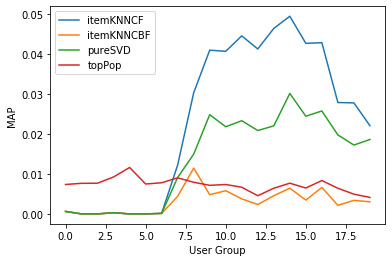

In [137]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_itemKNNCF_per_group, label="itemKNNCF")
pyplot.plot(MAP_itemKNNCBF_per_group, label="itemKNNCBF")
pyplot.plot(MAP_pureSVD_per_group, label="pureSVD")
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

In [114]:
cold_users_mask = np.ediff1d(URM_all.indptr) == 0
cold_users = np.arange(URM_all.shape[0])[cold_users_mask]
print(len(newUsers))
newUsers.extend(cold_users)
print(len(newUsers))

In [115]:
from pandas import DataFrame

recommended = []

def convertToStr(value_list):
   # Join all the strings in list
   final_str = values = ' '.join(str(v) for v in value_list)
   return final_str

for user_id in finalUsers:
    if(user_id in newUsers): 
#         print(user_id)
#         print(age)
#         print(UCM_all)
        
        age=UCM_all[user_id,0]
        geo=UCM_all[user_id,1]
        
        recommenderTopPop.fit2(URM_allMod,age)
            
        recommended.append(convertToStr(recommenderTopPop.recommend(user_id, at=10)))  
        
    else:
        recommended.append(convertToStr(collaborative_recommenderItemBased.recommend(user_id, at=10)))


Recs = {'user_id' : finalUsers, 'item_list' : recommended}

df = DataFrame(Recs)

export_csv = df.to_csv (r'D:\JupyterFolder\Data\export_dataframe.csv', index = None, header=True)
print (df)


In [116]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

file_len('D:\JupyterFolder\Data\export_dataframe.csv')

In [117]:
for user_id in newUsers[0:10]:
    print(recommenderTopPop.recommend(user_id, at=10))